# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

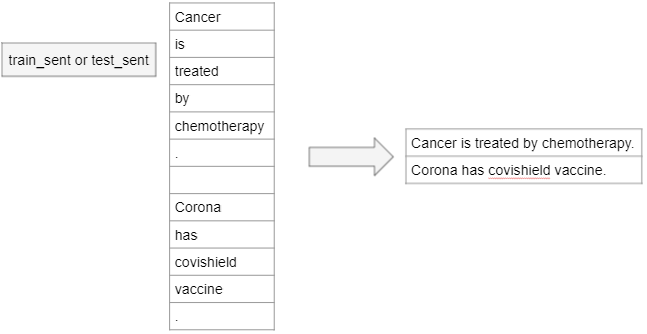

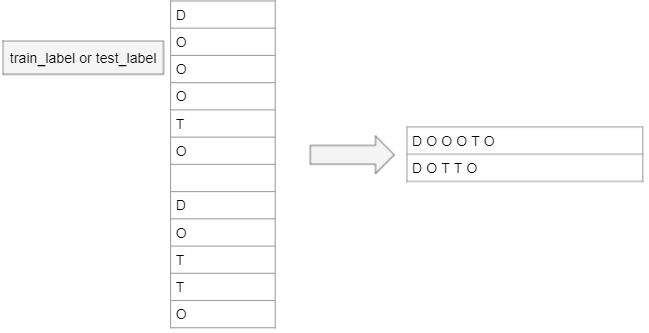

In [2]:
## Read the four given train and test files

with open("D:\\datasets\\NER_dataset\\train_sent",'r') as train_sent_file:
    train_sent=train_sent_file.read()


with open("D:\\datasets\\NER_dataset\\train_label",'r') as train_label_file:
    train_label=train_label_file.read()
    

with open("D:\\datasets\\NER_dataset\\test_sent",'r') as test_sent_file:
    test_sent=test_sent_file.read()
    

with open("D:\\datasets\\NER_dataset\\test_label",'r') as test_label_file:
    test_label=test_label_file.read()

    
print(train_sent)

All
live
births
>
or
=
23
weeks
at
the
University
of
Vermont
in
1995
(
n
=
2395
)
were
retrospectively
analyzed
for
delivery
route
,
indication
for
cesarean
,
gestational
age
,
parity
,
and
practice
group
(
to
reflect
risk
status
)

The
total
cesarean
rate
was
14.4
%
(
344
of
2395
)
,
and
the
primary
rate
was
11.4
%
(
244
of
2144
)

Abnormal
presentation
was
the
most
common
indication
(
25.6
%
,
88
of
344
)

The
``
corrected
''
cesarean
rate
(
maternal-fetal
medicine
and
transported
patients
excluded
)
was
12.4
%
(
273
of
2194
)
,
and
the
``
corrected
''
primary
rate
was
9.6
%
(
190
of
1975
)

Arrest
of
dilation
was
the
most
common
indication
in
both
``
corrected
''
subgroups
(
23.4
and
24.6
%
,
respectively
)

Cesarean
rates
at
tertiary
care
hospitals
should
be
compared
with
rates
at
community
hospitals
only
after
correcting
for
dissimilar
patient
groups
or
gestational
age

In
the
third
trimester
,
the
amniotic
fluid
index
(
AFI
)
may
be
affected
by
maternal
fluid
status

We
hypothesi

Define a function to convert given set of words into Sentences.<br>
Input: Data set containing individual words in separate lines.<br>
output: List contain the Sentences separeted by empty lines.


In [4]:
def words_to_sentences(words):
    words=words.split('\n\n')  
    list_of_sentences=[]
    for sent in words:
        list_of_sentences.append([item for item in sent.split('\n')])  # Create a list of lists containing words of sentences
    return[" ".join(i) for i in list_of_sentences]   # convert list of words to sentences

In [5]:
train_sent=words_to_sentences(train_sent)
train_label=words_to_sentences(train_label)
test_sent=words_to_sentences(test_sent)
test_label=words_to_sentences(test_label)

In [6]:
train_sent[:3]

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )',
 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )']

In [10]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

In [13]:
## View five train sentences along with their labels

train_df=pd.DataFrame({"sentences":train_sent,"labels":train_label})
train_df.head()

,sentences,labels
0,"All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
1,"The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )",O O O O O O O O O O O O O O O O O O O O O O O O O
2,"Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )",O O O O O O O O O O O O O O O
3,"The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
4,"Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )",O O O O O O O O O O O O O O O O O O O O O O


In [14]:
## View five test sentences along with their labels

test_df=pd.DataFrame({"sentences":test_sent,"labels":test_label})
test_df.head()


,sentences,labels
0,"Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
1,"As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration",O O O O O O O O O O O O O O O O O O O
2,The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period,O O O O O O O O O O O O O O O O O O O O O O O O
3,"There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )",O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
4,Fluctuations in ambient temperature are inversely correlated to changes in AFI,O O O O O O O O O O O


### Count the number of sentences in the processed train and test dataset 

In [17]:
print("The number of sentences in train set= {}".format(len(train_sent)))
print("The number of sentences in test set= {}".format(len(test_sent)))

The number of sentences in train set= 2600
The number of sentences in test set= 1057


### Count the number of lines of labels in the processed train and test dataset.

In [18]:
print("The number of line of labels in train set= {}".format(len(train_label)))
print("The number of line of labels in test set= {}".format(len(test_label)))

The number of line of labels in train set= 2600
The number of line of labels in test set= 1057


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



In [31]:
# let us extract the pos tag for one sentence in train_sent

doc=train_sent[2]
doc=model(doc)
for tok in doc:
    print(tok.text,"--" , tok.pos_)

Abnormal -- ADJ
presentation -- NOUN
was -- AUX
the -- DET
most -- ADV
common -- ADJ
indication -- NOUN
( -- PUNCT
25.6 -- NUM
% -- NOUN
, -- PUNCT
88 -- NUM
of -- ADP
344 -- NUM
) -- PUNCT


### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [26]:
## Extract tokens having PoS tag 'NOUN' or 'PROPN' from both training and test sentences and save them in one list 'nouns'
nouns = []

for sent in train_sent:
    doc = model(sent)
    for tok in doc:
        if tok.pos_=="NOUN" or tok.pos_ == "PROPN":
            nouns.append(tok.lemma_.lower())

for sent in test_sent:
    doc = model(sent)
    for tok in doc:
        if tok.pos_=="NOUN" or tok.pos_ == "PROPN":
            nouns.append(tok.lemma_.lower())
print(nouns)  

['birth', 'week', 'university', 'vermont', 'n', 'delivery', 'route', 'indication', 'cesarean', 'age', 'parity', 'practice', 'group', 'risk', 'status', 'rate', '%', 'rate', '%', 'presentation', 'indication', '%', 'rate', 'medicine', 'patient', '%', 'rate', '%', 'arrest', 'dilation', 'indication', 'subgroup', '%', 'rate', 'care', 'hospital', 'rate', 'community', 'hospital', 'group', 'age', 'trimester', 'index', 'afi', 'status', 'temperature', 'increase', 'decrease', 'afi', 'june', 'august', 'period', 'heat', 'woman', 'singleton', 'pregnancy', 'week', 'gestation', 'testing', 'afi', 'determination', 'temperature', 'area', '2-', '3-', '4-day', 'temperature', 'test', 'date', 'afi', 'spearman', 'rank', 'correlation', 'relationship', 'account', 'afi', 'measure', 'well', 'being', 'study', 'population', 'woman', 'diabete', 'screening', 'woman', 'clinic', 'hadassah', 'medical', 'center', 'period', 'woman', '%', 'treatment', 'week', 'group', 'woman', '%', 'treatment', 'week', 'group', 'patient', '

In [32]:
noun_series=pd.Series(nouns).value_counts()
noun_series

patient                            565
treatment                          316
%                                  247
study                              236
cancer                             226
cell                               202
therapy                            182
effect                             181
disease                            170
group                              145
case                               132
lung                               120
gene                               111
rate                               103
chemotherapy                        91
use                                 90
trial                               90
woman                               89
conclusion                          89
result                              87
analysis                            86
protein                             82
response                            81
year                                79
risk                                78
child                    

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [30]:
noun_series.head(25)

patient         565
treatment       316
%               247
study           236
cancer          226
cell            202
therapy         182
effect          181
disease         170
group           145
case            132
lung            120
gene            111
rate            103
chemotherapy     91
use              90
trial            90
woman            89
conclusion       89
result           87
analysis         86
protein          82
response         81
year             79
risk             78
dtype: int64

## Defining features for CRF





In [34]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(words_of_sentence, i, token_Pos_list):
    '''
    Parameters:
    'words_of_sentences': list of all words in a sentence
    'i' : position of the word 
    'token_Pos_list': list of PoS tags of corresponding words in above list 'words_of_sentences'
    
    Returns:
    'features': a list of all the features of the word at ith position in the list 'words_of_sentences'
    
    '''
    word = words_of_sentence[i]

    features = [
        'word.Pos=' + token_Pos_list[i], # PoS tag of the word
        'word.lower=' + word.lower(),    # word in lower case
        'word[-3:]=' + word[-3:],        # last three characters
        'word[-2:]=' + word[-2:],        # last two characters
        'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
        'word.isdigit=%s' % word.isdigit(),  # is the word a number
        'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
      ]
        
    if(i > 0):
            prev_word = words_of_sentence[i-1]
            features.extend([
                'prev_word.Pos=' + token_Pos_list[i-1], # PoS tag of the previous word
                'prev_word.lower=' + prev_word.lower(), # previous word in lower case
                'prev_word[-3:]=' + prev_word[-3:],        # last three characters of previous word
                'prev_word[-2:]=' + prev_word[-2:],        # last two characters of previous word
                'prev_word.isupper=%s' % prev_word.isupper(), # is the previous word in all uppercase
                'prev_word.isdigit=%s' % prev_word.isdigit(), # is the previous word a number
                'prev_words.startsWithCapital=%s' % prev_word[0].isupper() # is the previous word starting with a capital letter
      ])
        
    else:
            features.append('BEG') # feature to track begin of sentence 
        
        
    if(i == len(words_of_sentence)-1):
            features.append('END') # feature to track end of sentence
        
    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [40]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    doc = model(sentence)
    token_Pos_list = [tok.pos_ for tok in doc]
    words_of_sentence = sentence.split()
    return [getFeaturesForOneWord(words_of_sentence, i, token_Pos_list) for i in range(len(words_of_sentence))]

In [43]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 2 in train_sent
example_sentence = train_sent[2]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features

Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )


[['word.Pos=ADJ',
  'word.lower=abnormal',
  'word[-3:]=mal',
  'word[-2:]=al',
  'word.isupper=False',
  'word.isdigit=False',
  'words.startsWithCapital=True',
  'BEG'],
 ['word.Pos=NOUN',
  'word.lower=presentation',
  'word[-3:]=ion',
  'word[-2:]=on',
  'word.isupper=False',
  'word.isdigit=False',
  'words.startsWithCapital=False',
  'prev_word.Pos=ADJ',
  'prev_word.lower=abnormal',
  'prev_word[-3:]=mal',
  'prev_word[-2:]=al',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_words.startsWithCapital=True'],
 ['word.Pos=AUX',
  'word.lower=was',
  'word[-3:]=was',
  'word[-2:]=as',
  'word.isupper=False',
  'word.isdigit=False',
  'words.startsWithCapital=False',
  'prev_word.Pos=NOUN',
  'prev_word.lower=presentation',
  'prev_word[-3:]=ion',
  'prev_word[-2:]=on',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_words.startsWithCapital=False'],
 ['word.Pos=DET',
  'word.lower=the',
  'word[-3:]=the',
  'word[-2:]=he',
  'word.isupper=False',
 

### Write a code/function to get the labels of a sentence

In [44]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [45]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [46]:
y_train = [getLabelsInListForOneSentence(labels) for labels in train_label]
y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]

## Build the CRF Model

In [47]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=1)

crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|██████████| 2600/2600 [00:00<00:00, 6248.30it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 26687
Seconds required: 0.095

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.04  loss=23237.10 active=26141 feature_norm=1.00
Iter 2   time=0.02  loss=22141.27 active=25287 feature_norm=0.89
Iter 3   time=0.02  loss=21224.81 active=25010 feature_norm=0.70
Iter 4   time=0.02  loss=20474.78 active=26453 feature_norm=0.79
Iter 5   time=0.02  loss=19060.82 active=26389 feature_norm=1.05
Iter 6   time=0.02  loss=16881.18 active=26535 feature_norm=1.37
Iter 7   time=0.02  loss=13714.14 active=26435 feature_norm=3.51
Iter 8   time=0.02  loss=13275.95 active=26498 feature_norm=3.62
Iter 9   time=0.02  loss=12518.69 active=26532 feature_norm=3.68
Iter 10  time=

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [49]:
y_pred = crf.predict(X_test)
y_pred

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',


### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [50]:
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.9206741405448909

In [72]:
id = 4
print("Sentence:",test_sent[id])
print("Orig Labels:", y_test[id])
print("Pred Labels:", y_pred[id])

Sentence: Fluctuations in ambient temperature are inversely correlated to changes in AFI
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

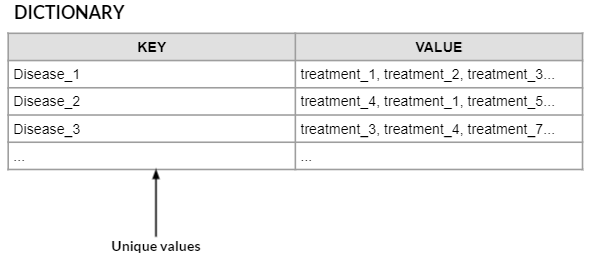

In [52]:
disease_indices=[]
for row in y_pred:
    disease_indices.append([i for i, x in enumerate(row) if x == 'D'])
print(disease_indices)

[[], [], [], [], [], [11, 12, 13, 14, 15, 16], [], [], [], [], [], [], [10, 16, 17, 18], [12], [], [3, 4], [], [], [], [], [6, 7, 8], [20, 21, 22, 23], [], [], [], [], [], [16], [], [37, 38, 43, 44, 50, 51], [], [], [], [6, 7], [11, 12], [], [10, 11, 12], [19, 20], [], [14, 15, 16, 17, 18], [], [], [], [], [], [], [13, 17, 18], [], [], [], [], [], [], [10, 11], [], [], [], [], [], [], [], [9, 11], [], [], [], [], [], [], [], [], [], [27, 28, 29, 30, 31, 32], [], [18, 19], [], [9, 10, 11], [], [], [], [], [], [], [], [], [], [], [], [], [6, 7], [8, 9], [], [], [], [], [], [], [], [], [], [], [33, 34], [], [], [22, 23, 24, 25, 30, 31], [], [12, 13, 14, 15], [], [], [], [4, 5], [], [34], [], [], [], [20, 21, 22, 23, 24, 25, 26, 27], [], [], [], [29, 30], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [0], [], [], [], [], [], [], [], [], [6, 7], [], [], [44], [], [11, 12], [], [5, 8, 9], [], [8, 9], [20, 21], [], [6, 7], [], [], [11, 12], [], []

In [53]:
## Now we will use above disease_indices to slice our test sentences to get names of Diseases

diseases = []

for i in range(len(disease_indices)):
    list_D = []
    for j in disease_indices[i]:
        list_D.append(test_sent[i].split()[j])
    diseases.append(list_D)
diseases

[[],
 [],
 [],
 [],
 [],
 ['macrosomic', 'infants', 'in', 'gestational', 'diabetes', 'cases'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['microcephaly', 'nonimmune', 'hydrops', 'fetalis'],
 ['preeclampsia'],
 [],
 ['severe', 'preeclampsia'],
 [],
 [],
 [],
 [],
 ['asymmetric', 'double', 'hemiplegia'],
 ['reversible', 'nonimmune', 'hydrops', 'fetalis'],
 [],
 [],
 [],
 [],
 [],
 ['cancer'],
 [],
 ['breast', 'cancer', 'breast', 'cancer', 'ovarian', 'cancer'],
 [],
 [],
 [],
 ['prostate', 'cancer'],
 ['prostate', 'cancers'],
 [],
 ['hereditary', 'prostate', 'cancer'],
 ['prostate', 'cancer'],
 [],
 ['multiple', 'sclerosis', '(', 'MS', ')'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['cancer', 'hereditary', 'retinoblastoma'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['pericardial', 'effusions'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['epilepsy', 'ADHD'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['unstable', 'angina', 'or', 'non-Q-wave', 'myocardial', 'infarction'],
 [],
 ['coronary-artery', 'disease'],
 [],
 ['early-

In [54]:
treatment_indices=[]
for row in y_pred:
    treatment_indices.append([i for i, x in enumerate(row) if x == 'T'])
print(treatment_indices)

[[], [], [], [], [], [18, 19, 20], [], [], [], [], [], [], [0], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [24], [], [], [], [], [], [], [], [], [17, 18], [], [], [], [12], [], [2], [], [], [], [], [], [], [19, 20, 21, 22, 23, 27, 28, 29, 30, 31, 32, 36], [19, 42, 43, 44, 48], [], [5], [], [2, 3], [12, 13], [], [], [], [], [21, 22, 23, 24], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [45, 46, 47, 48, 49, 50, 51], [], [], [], [], [], [], [], [], [], [], [], [], [], [21, 22], [13, 14], [15], [], [], [11], [4], [], [], [], [], [], [], [], [], [], [9, 10, 11], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [0, 1, 2, 3, 4, 5], [], [7, 8, 9, 10, 11], [], [5, 6, 88, 89, 90], [], [2, 3], [], [16, 17, 31], [2, 3], [], [14], [], [], [], [], [1], [10], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [0, 1], [15, 16, 17, 19, 2

In [55]:
## Now we will use above treatment_indices to slice our test sentences to get names of treatments 

treatments = []

for i in range(len(treatment_indices)):
    list_T = []
    for j in treatment_indices[i]:
        list_T.append(test_sent[i].split()[j])
    treatments.append(list_T)
treatments

[[],
 [],
 [],
 [],
 [],
 ['good', 'glycemic', 'control'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Trisomy'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['radiotherapy'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['hearing', 'aids'],
 [],
 [],
 [],
 ['methylphenidate'],
 [],
 ['Methylphenidate'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['aspirin',
  ',',
  '3',
  'mg',
  'warfarin',
  'aspirin',
  ',',
  'or',
  '1',
  'mg',
  'warfarin',
  'aspirin'],
 ['aspirin', '1', 'mg', 'warfarin', 'aspirin'],
 [],
 ['roxithromycin'],
 [],
 ['Antichlamydial', 'antibiotics'],
 ['radical', 'radiotherapy'],
 [],
 [],
 [],
 [],
 ['beta', 'human', 'chorionic', 'gondotropin'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['electrical', 'nerve', 'stimulation', '(', 'ENS', ')', 'therapy'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 

In [56]:
## Create a dataframe containing Diseases and Treatments
final_df=pd.DataFrame({'Diseases':diseases,'Treatments':treatments})
final_df    

,Diseases,Treatments
0,[],[]
1,[],[]
2,[],[]
3,[],[]
4,[],[]
5,"[macrosomic, infants, in, gestational, diabetes, cases]","[good, glycemic, control]"
6,[],[]
7,[],[]
8,[],[]
9,[],[]


In [69]:
final_df=final_df[(final_df.Diseases.map(lambda x: len(x)) > 0)]
final_df=final_df[(final_df.Treatments.map(lambda x: len(x)) > 0)]
final_df

,Diseases,Treatments
5,"[macrosomic, infants, in, gestational, diabetes, cases]","[good, glycemic, control]"
12,"[microcephaly, nonimmune, hydrops, fetalis]",[Trisomy]
46,"[cancer, hereditary, retinoblastoma]",[radiotherapy]
61,"[epilepsy, ADHD]",[Methylphenidate]
71,"[unstable, angina, or, non-Q-wave, myocardial, infarction]",[roxithromycin]
73,"[coronary-artery, disease]","[Antichlamydial, antibiotics]"
115,"[fenfluramines, to, primary, pulmonary, hypertension, (, PPH, )]",[fenfluramines]
119,"[essential, hypertension]",[moxonidine]
155,[cellulitis],"[G-CSF, therapy, intravenous, antibiotic, treatment]"
157,"[foot, infection]","[G-CSF, treatment]"


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [73]:
for row1, row2 in list(zip(final_df['Diseases'],final_df['Treatments'])):
    if ('hereditary' in row1 and 'retinoblastoma' in row1):
        print(row1, '-', row2)

['cancer', 'hereditary', 'retinoblastoma'] - ['radiotherapy']


#### The predicted treatment of `hereditary retinoblastoma` is `radiotherapy` as per the model